# Importing requirements

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import Counter

m,n,q = 640,256,113
def generate_e(sigma,size=m):
    return np.random.normal(0,sigma,size=size).reshape(-1,1).astype(int)

accuracy = lambda x,y: (x==y).sum()/len(y)*100
print_minmax = lambda b: print(f"min: {b.min()}\nmax: {b.max()}")

def initialize_expt(m=m,n=n,q=q,sigma_factor=0.05,seed=None,verbose=1):

    sigma = sigma_factor*q
    if seed is not None: np.random.seed(seed)
    A = np.round(np.random.rand(m,n)).astype(int)
    S = np.round(np.random.rand(n,1)).astype(int)

    e = generate_e(sigma,size=m)

    b = (A@S + e) % q
    if verbose:
        print("Initialized LWE instance.")
        print("Range of b:")
        print_minmax(b)

    return A,S,e,b,sigma

## Jump to section:
1. [Exploration](#exploration)
2. [Scoring based method](#scoring)
3. [Using $Ax_i$=$u_i$](#methodaxu)
4. [Encryption using LWE](#encryption)
   1. [Effects on parameters on decryption accuracy](#encryption_effects)

<a class="anchor" id="index"></a>

<a class="anchor" id="exploration"></a>
# Exploration
[Back to top](#index)

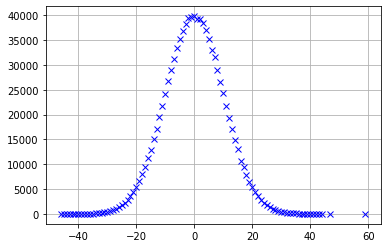

In [8]:
k = np.random.normal(0,10,size=1000000)

def plot_distribution(k):
    k = np.round(k).reshape(-1,)
    plt.plot(Counter(k).keys(),Counter(k).values(),"bx")
    plt.grid()
    
plot_distribution(k)

In [9]:
m = 640
n = 256
q = 113
sigma = 1/n*q
seed = 69

np.random.seed(seed)
A = np.round(np.random.rand(m,n)).astype(int)
S = np.round(np.random.rand(n,1)).astype(int)

generate_e = lambda sig: np.round(np.random.normal(0,sig,size=m).reshape(m,1)).astype(int)
e = generate_e(sigma)

b = (A@S % q + e % q) % q

In [10]:
print(f"min: {b.min()}\nmax: {b.max()}")

min: 48
max: 77


In [ ]:
lstsq_sol = np.linalg.lstsq(A,b,rcond=0)[0]
plot_distribution(lstsq_sol)

In [18]:
thresh = 0.5
lstsq_sol[lstsq_sol>thresh]=1
lstsq_sol[lstsq_sol<thresh]=0

In [19]:
accuracy = lambda x,y: (x==y).sum()/len(y)*100
accuracy(lstsq_sol,S)

100.0

In [11]:
try:
    atainv = np.linalg.inv(A.T@A)
    pred_knownE = np.round(atainv@A.T@(b-e)).astype(int)
    pred_unknownE = np.round(atainv@A.T@(b-generate_e(sigma))).astype(int)
    print(accuracy(pred_knownE,S),accuracy(pred_unknownE,S),sep='\n')
except np.linalg.LinAlgError:
    print("A.T@A is not invertible")

100.0
46.875


# Testing a scoring based method 
<a id="scoring"></a>
[Back to top](#index)


In [249]:
A,S,e,b,sigma = initialize_expt()

Initialized LWE instance.
Range of b:
min: 34
max: 82


In [269]:
def run(num_iter=100,update_interval=10,q=q,sigma_factor=0.05,seed=None,plot=True,verbose=1):
    if seed is not None: np.random.seed(seed)
    A,S,e,b,sigma = initialize_expt(q=q,sigma_factor=sigma_factor,seed=np.random.randint(0,1e5),verbose=verbose)
    if verbose: 
        print("Range of e:")
        print_minmax(e)

    scores = np.zeros((A.shape[1],2))
    acc = []

    pbar = tqdm(range(num_iter),ncols=100) if verbose else range(num_iter)
    for i in pbar:
        b_ = (b - generate_e(sigma)) % q
        sol = np.linalg.lstsq(A,b_,rcond=0)[0]

        thresh = sol.mean()
        sol[sol>thresh] = 1
        sol[sol<thresh] = 0

        for n,s in enumerate(sol):
            scores[n][int(s)] += 1

        if i % update_interval == 0:
            temp_sol = np.argmax(scores,axis=1).reshape(-1,1)
            acc.append([i,accuracy(temp_sol,S)])
        
    if plot:
        plt.figure(figsize=(7,5))
        plt.plot(acc);plt.plot(acc,'bo')
        plt.title("Accuracy vs iterations")
        plt.xlabel("Iteration");plt.ylabel("Accuracy")
        plt.show()

    return np.array(acc), acc[-1][1]

In [259]:
sigmas = np.linspace(1/n,0.05,10)

accs = []
for sigma in tqdm(sigmas,ncols=100):
    accs.append(run(num_iter=100,sigma_factor=sigma,plot=False,verbose=0)[0])
accs = np.array(accs)

100%|███████████████████████████████████████████████████████████████| 10/10 [02:40<00:00, 16.08s/it]


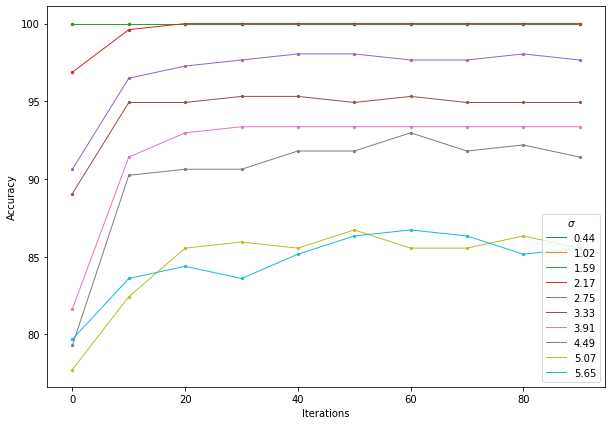

In [268]:
plt.figure(figsize=(10,7))
for i,acc in enumerate(accs):
    plt.plot(acc[:,0],acc[:,1],label=str(sigmas[i]*q)[:4],linewidth=1);plt.scatter(acc[:,0],acc[:,1],s=5)
    plt.legend(title=r"$\sigma$")
    plt.xlabel("Iterations");plt.ylabel("Accuracy")
plt.show()

In [256]:
res = []
for sigma in sigmas:
    runs = []
    for r in tqdm(range(20)):
        runs.append(run(num_iter=20,sigma_factor=sigma,plot=False,verbose=0)[1])
    res.append([sigma,np.mean(runs)])
res = np.array(res)

100%|██████████| 20/20 [00:52<00:00,  2.61s/it]


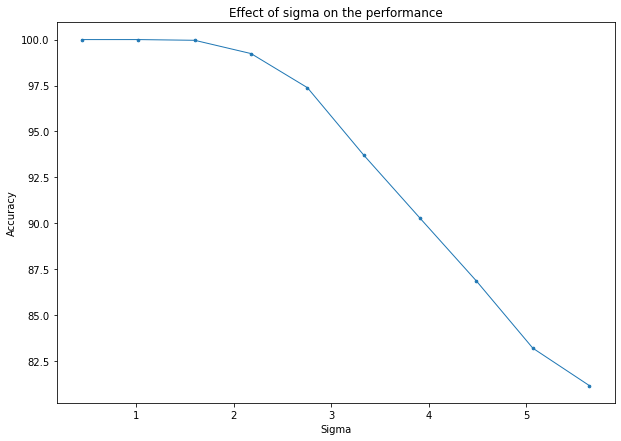

In [257]:
plt.figure(figsize=(10,7))
plt.plot(res[:,0]*q,res[:,1],linewidth=1);plt.scatter(res[:,0]*q,res[:,1],s=7)    
plt.title("Effect of sigma on the performance")
plt.xlabel("Sigma");plt.ylabel("Accuracy")
plt.show()

For lower errors, least squares is a reasonable approximation

<a class="anchor" id="methodaxu"></a>
# Method 2:
## Finding $x_i$'s such that $Ax_i = u_i$

An attacker can take the transpose of $b$, giving $b^T$, and multiply by $x_i's$ to get the corresponding bit value of s

$$
\begin{align*}
b &= A \times S + e \\
b^T &= S^T \times A^T + e^T \\
b^T \times x_i &= S^T \times u_i + e^T \times x_i \\
b^T \times x_i &= S^T_i + e^T \times x_i \\
\end{align*}
$$

The attacker knows $b^T$, hopes the norm of $x_i$ is small enough, and then approximates the bit $S^T_i$ using the output 

In [293]:
A,S,e,b,sigma = initialize_expt()

Initialized LWE instance.
Range of b:
min: 34
max: 82


In [295]:
def run_axu(m=m,n=n,q=q,sigma_factor=0.05,seed=None,shownorms=False):
    if seed is not None: np.random.seed(seed)
    A,S,e,b,sigma = initialize_expt(m=m,n=n,q=q,sigma_factor=sigma_factor,seed=np.random.randint(0,1e5),verbose=0)
    
    U = np.eye(n)
    X = np.linalg.lstsq(A.T,U,rcond=0)[0]
   
    preds = np.round((b.T@X).reshape(-1,1))
    acc = accuracy(preds,S)

    norms,enorms = [],[]

    if shownorms:
        for i in range(len(U)):
            norms.append(np.linalg.norm(X[:,i]))
            enorms.append((e.T@X[:,i])[0])    
        print(f"Maximum norms :\t x_{np.argmax(norms)+1} = {max(norms):.4f}\te.T@x_{np.argmax(enorms)+1} = {max(enorms):.4f}")

    return acc

In [283]:
acc1 = run_axu(sigma_factor=0.05,shownorms=True)
acc2 = run_axu(sigma_factor=1/n,shownorms=True)

Maximum norms :	 x_173 = 0.1110	e.T@x_178 = 1.5334
Maximum norms :	 x_136 = 0.1090	e.T@x_240 = 0.0522


Sigma heavily affects the norm which will directly impact the rounding off

In [220]:
sigmas = np.linspace(1/n,0.05,100)

res = []
for sigma in tqdm(sigmas,ncols=100):
    iter = []
    for i in range(20):
        iter.append(run_axu(sigma_factor=sigma))
    res.append([sigma,np.mean(iter)])

res = np.array(res)
np.save("../results/axu_varsigma.npy",res)

100%|█████████████████████████████████████████████████████████████| 100/100 [11:43<00:00,  7.04s/it]


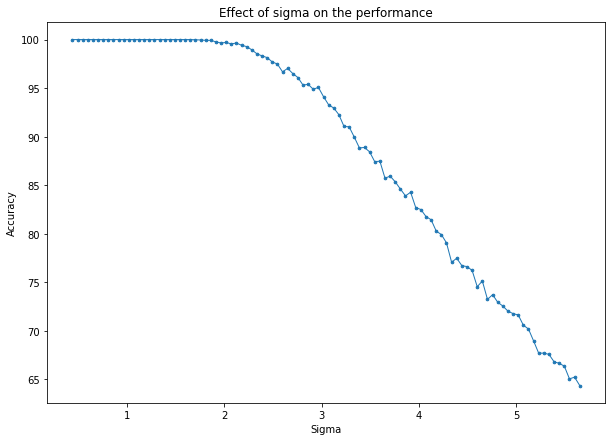

In [230]:
res = np.load("../results/axu_varsigma.npy")
plt.figure(figsize=(10,7))
plt.plot(res[:,0]*q,res[:,1],linewidth=1);plt.scatter(res[:,0]*q,res[:,1],s=7)    
plt.title("Effect of sigma on the performance")
plt.xlabel("Sigma");plt.ylabel("Accuracy")
plt.show()

array([ 128.,  256.,  384.,  512.,  640.,  768.,  896., 1024.])

In [304]:
ns = np.linspace(128,1024,10).astype(int)

res = []
for n_ in tqdm(ns,ncols=100):
    iter = []
    for i in range(20):
        iter.append(run_axu(n=n_))
    res.append([n_,np.mean(iter)])

res = np.array(res)
np.save("../results/axu_varn.npy",res)

100%|███████████████████████████████████████████████████████████████| 10/10 [08:09<00:00, 48.92s/it]


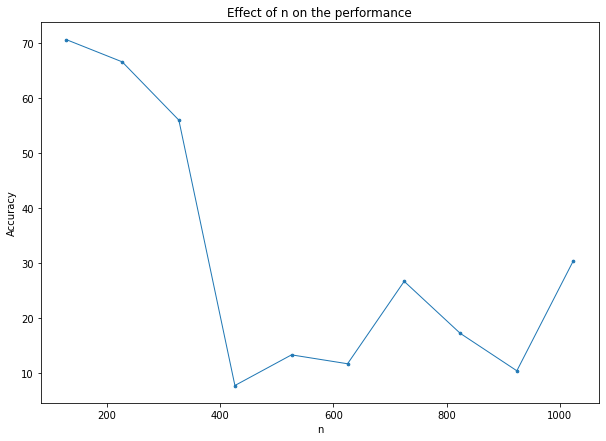

In [306]:
res = np.load("../results/axu_varn.npy")
plt.figure(figsize=(10,7))
plt.plot(res[:,0],res[:,1],linewidth=1);plt.scatter(res[:,0],res[:,1],s=7)    
plt.title("Effect of n on the performance")
plt.xlabel("n");plt.ylabel("Accuracy")
plt.show()

## Experimenting with $x_i$'s such that $Ax_i = u_i+u_{i+1}$
The equations we will get are:
$$
S^T_i + S^T_{i+1} = b^T \times x_i
$$
Therefore, if we know S^T_0, the first bit of S, we can successively subtract and round off to get the next bits of S

In [270]:
A,S,e,b,sigma = initialize_expt()

Initialized LWE instance.
Range of b:
min: 34
max: 82


In [ ]:
U = np.eye(n)
norms = []
enorms = []

def stagger_and_add(mat,stagger=1):
    mat_orig = mat.copy()
    for i in range(1,stagger+1):
        mat = np.vstack((mat_orig[i:],mat_orig[0:i])) + mat
    return mat

stagger_ls = [i for i in range(50)]

maxnorms = np.zeros((len(stagger_ls),2))
maxenorms = np.zeros((len(stagger_ls),2))
for ii,st in enumerate(tqdm(stagger_ls,ncols=100)):
    X = np.linalg.lstsq(A.T,stagger_and_add(U,st),rcond=0)[0].T
    for i in range(len(U)):
        norms.append(np.linalg.norm(X[i]))
        enorms.append((e.T@X[i])[0])
    maxnorms[ii] = (st,max(norms))
    maxenorms[ii] = (st,max(np.abs(enorms)))
    
    # print(f"Maximum norms :\t x_{np.argmax(norms)+1} = {max(norms):.4f}\te.T@x_{np.argmax(enorms)+1} = {max(enorms):.4f}")

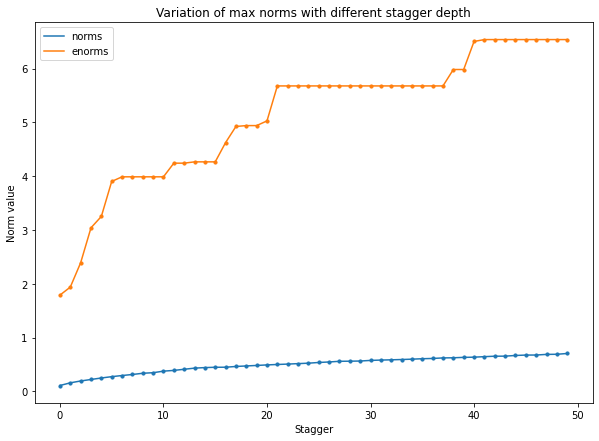

In [276]:
plt.figure(figsize=(10,7))
plt.plot(maxnorms[:,0],maxnorms[:,1],label="norms")
plt.scatter(maxnorms[:,0],maxnorms[:,1],s=10)
plt.plot(maxenorms[:,0],maxenorms[:,1],label="enorms")
plt.scatter(maxenorms[:,0],maxenorms[:,1],s=10)
plt.xlabel("Stagger");plt.ylabel("Norm value")
plt.title("Variation of max norms with different stagger depth");plt.legend();plt.show()

In [207]:
from sklearn.preprocessing import MinMaxScaler

def run_axu_stagger(sigma_factor=0.05,stagger=1):
    A,S,e,b,sigma = initialize_expt(sigma_factor=sigma_factor,seed=np.random.randint(0,1e5),verbose=0)
    
    U = np.eye(n)

    X = np.linalg.lstsq(A.T,stagger_and_add(U,stagger),rcond=0)[0]
   
    sums = (b.T@X).reshape(-1,1)

    sums = MinMaxScaler((0,stagger+1)).fit_transform(sums).reshape(-1,)

    preds = list(S[:stagger,0])
    for i in range(len(sums)-1):
        diff = sums[i]-sum(preds[i:stagger])
        dist0 = np.linalg.norm(diff-0)
        dist1 = np.linalg.norm(diff-1)

        pred = 0 if dist0 < dist1 else 1
        preds.append(pred)

    preds = np.array(preds).reshape(-1,1)
    acc = accuracy(preds,S)

    return acc

In [205]:
print("Average success rate:",np.mean([run_axu_stagger(sigma_factor=1/n) for i in range(100)]))

Average success rate: 49.890625


<a class="anchor" id="encryption"></a>
# Encryption using LWE

In [78]:
A,S,e,b,sigma = initialize_expt(sigma_factor=1/n)

Initialized LWE instance.
Range of b:
min: 45
max: 83


In [79]:
def encrypt_using_lwe(M,A,S,sigma,q,seed=None,r_precision=1):
    if seed is not None: np.random.seed(seed)
    try: 
        lenm = len(M)
        M = M.reshape(-1,1)
    except: lenm = 1


    r = np.round(np.random.rand(lenm,A.shape[0]))/r_precision
    e = generate_e(sigma,size=A.shape[0])
    c0 = r@A % q
    c1 = r @ (A@S+e) + (M * np.round(q/2))
    c1 = c1 % q

    return np.hstack((c0,c1)).flatten()

def decrypt_lwe(c,A,S,b,q):
    c = c.reshape(-1,len(S)+1)
    (c0,c1) = np.hsplit(c,[len(S)])

    Mdash = np.array(abs(c1 - c0@S % q))
    out = []

    for M_ in Mdash:
        if M_ < q - M_:
            out.append((abs(M_) > abs(np.ceil(q/2)-M_)).astype(int))
        else:
            out.append((abs(M_-q) > abs(np.ceil(q/2)-M_)).astype(int))
    return np.array(out).reshape(-1,1)

In [80]:
def encrypt_decrypt_cycle(M,A,S,b,q,r_precision=1):
    outputs = []
    for M_ in M:
        c = encrypt_using_lwe(M_,A,S,sigma,q,r_precision=r_precision)
        Mdash = decrypt_lwe(c,A,S,b,q)
        outputs.append(Mdash==M_)

    return 100*np.sum(outputs)/len(outputs)

In [81]:
for i in range(100):
    f = 1
    if encrypt_decrypt_cycle(np.round(np.random.rand(10)),A,S,b,q,r_precision=1) != 100:
        print("fail");f = 0;break
if f: print("all pass")

all pass


In [82]:
def encrypt_text(M,A,S,sigma,q,seed=None,r_precision=1):
    Mbin = "".join(f"{ord(i):08b}" for i in M)
    Mbin_arr = np.array([int(i) for i in Mbin]).reshape(-1,1)

    c = encrypt_using_lwe(Mbin_arr,A,S,sigma,q,seed,r_precision=r_precision)
    return "".join(chr(int(i)) for i in c)


def decrypt_text(c,A,S,b,q):
    c = np.array([ord(i) for i in c]).reshape(-1,1)
    Mbin_arr = decrypt_lwe(c,A,S,b,q).squeeze()
   
    out = ""
    for i in range(0,len(Mbin_arr),8):
        Mbin_str = "".join(str(i) for i in Mbin_arr[i:i+8])
        out += chr(int(Mbin_str,2))
    return out

In [83]:
test_str = "Hello there this is a test string"

cyphertext = encrypt_text(test_str,A,S,sigma,q,r_precision=1) 
print(f"Original message length: {len (test_str)}")
print(f"Encrypted message length: {len(cyphertext)}\nSample: \"{cyphertext[:20]}\"")
print(f"Decrypted message: \"{decrypt_text(cyphertext,A,S,b,q)}\"")

Original message length: 33
Encrypted message length: 67848
Sample: "0/&6/.844//42/2*5=,2"
Decrypted message: "Hello there this is a test string"


In [84]:
print(len(test_str)*257*8)

67848


Size increases by a factor of **(Secret size + 1) * 8**, if alphabets/characters to be encrypted are all 8 bit

<a class="anchor" id="encryption_effects"></a>

## Effect of parameters on decryption accuracy

In [75]:
import string, random

generate_msg = lambda msg_size: "".join(random.choice(string.ascii_letters) for i in range(msg_size))
print(generate_msg(100))

WcFENwlFmGSDtgKVkwKKSlLZxmnorGkXRyHMqYpvsDCeeYpDkLDxUfLlzlTvstpUgyTigpsWHmBHqaMWNnNupnIjpOSnMknUQWvI


In [76]:
def str_acc(s,t):
    c = 0
    assert len(s)==len(t), "Length mismatch!"
    
    for i in range(len(s)):
        if s[i]==t[i]: c += 1
    return 100*c/len(s)

def run2(num_iter,m=m,n=n,q=q,sigma_factor=0.05,seed=None,msg_size=100,verbose=0):
    if seed is not None: 
        np.random.seed(seed);random.seed(seed)

    A,S,e,b,sigma = initialize_expt(m,n,q,sigma_factor,verbose=0)

    pbar = tqdm(range(num_iter),ncols=100) if verbose else range(num_iter)
    
    accs = []
    for i in pbar:
        msg = generate_msg(msg_size)
        accs.append(str_acc(decrypt_text(encrypt_text(msg,A,S,sigma,q),A,S,b,q),msg))
    
    return np.mean(accs)

In [57]:
sigmas = np.linspace(1/n,0.02,30)

res = []
for sigma in tqdm(sigmas,ncols=100):
    res.append([sigma*q,run2(num_iter=50,verbose=0,sigma_factor=sigma)])

res = np.array(res)

100%|███████████████████████████████████████████████████████████████| 30/30 [03:26<00:00,  6.88s/it]


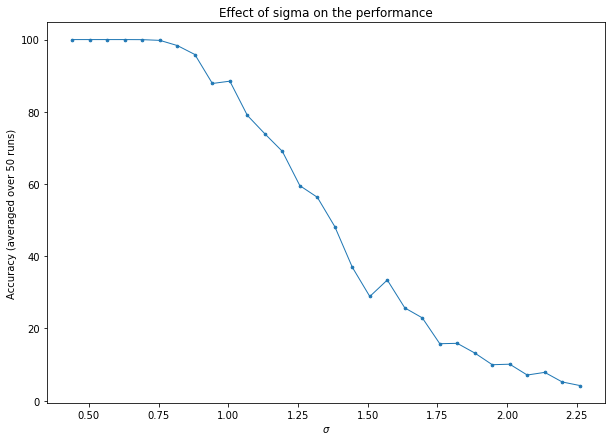

In [58]:
plt.figure(figsize=(10,7))
plt.plot(res[:,0],res[:,1],linewidth=1); plt.scatter(res[:,0],res[:,1],s=7)      # type: ignore
plt.title("Effect of sigma on the performance")
plt.xlabel(r"$\sigma$");plt.ylabel("Accuracy (averaged over 50 runs)")
plt.show()

Accuracy starts falling for $\sigma \approx 0.75 \approx 0.007q$ 

In [93]:
qs = np.linspace(113,1023,500).astype(int)

resq = []
for q_ in tqdm(qs,ncols=100):
    resq.append([q_,run2(q=q_,num_iter=25,verbose=0,sigma_factor=0.007)])

resq = np.array(resq)

100%|█████████████████████████████████████████████████████████████| 500/500 [27:46<00:00,  3.33s/it]


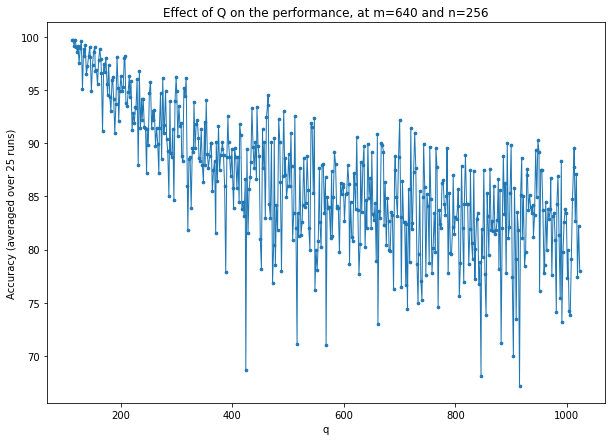

In [96]:
plt.figure(figsize=(10,7))
plt.plot(resq[:,0],resq[:,1],linewidth=1); plt.scatter(resq[:,0],resq[:,1],s=7)      # type: ignore
plt.title("Effect of Q on the performance, at m=640 and n=256")
plt.xlabel("q");plt.ylabel("Accuracy (averaged over 25 runs)")
plt.show()

In [88]:
secret_lens = np.linspace(128,1024,50).astype(int)

ress = []
for n_ in tqdm(secret_lens,ncols=100):
    ress.append([n_,run2(n=n_,num_iter=50,verbose=0,sigma_factor=0.007)])

ress = np.array(ress)

100%|███████████████████████████████████████████████████████████████| 50/50 [09:53<00:00, 11.87s/it]


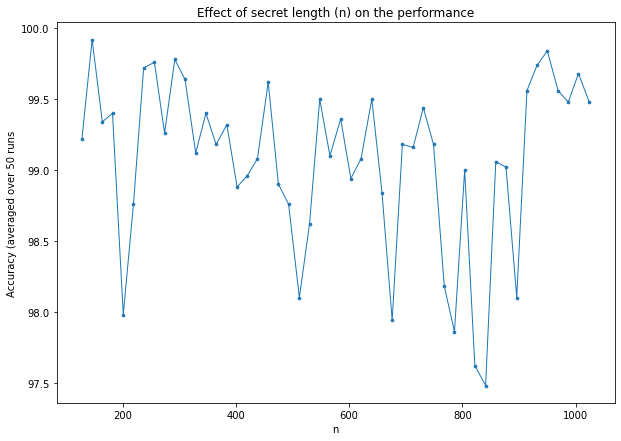

In [89]:
plt.figure(figsize=(10,7))
plt.plot(ress[:,0],ress[:,1],linewidth=1); plt.scatter(ress[:,0],ress[:,1],s=7)      # type: ignore
plt.title("Effect of secret length (n) on the performance")
plt.xlabel("n");plt.ylabel("Accuracy (averaged over 50 runs")
plt.show()

In [90]:
eq_lens = np.linspace(500,2000,50).astype(int)

resm = []
for m_ in tqdm(eq_lens,ncols=100):
    resm.append([m_,run2(m=m_,num_iter=50,verbose=0,sigma_factor=0.007)])

resm = np.array(resm)

100%|███████████████████████████████████████████████████████████████| 50/50 [05:56<00:00,  7.13s/it]


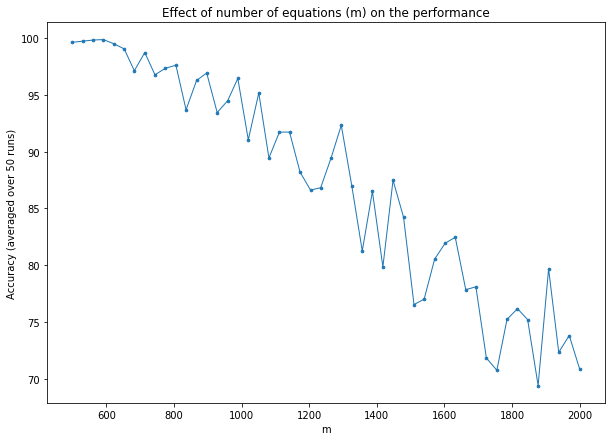

In [92]:
plt.figure(figsize=(10,7))
plt.plot(resm[:,0],resm[:,1],linewidth=1); plt.scatter(resm[:,0],resm[:,1],s=7)      # type: ignore
plt.title("Effect of number of equations (m) on the performance")
plt.xlabel("m");plt.ylabel("Accuracy (averaged over 50 runs)")
plt.show()